# Experiments Gaussian HHM

In [1]:
from dynamax.hidden_markov_model import GaussianHMM
from dynamax.hidden_markov_model import DiagonalGaussianHMM
from dynamax.hidden_markov_model import SphericalGaussianHMM
from dynamax.hidden_markov_model import SharedCovarianceGaussianHMM
import matplotlib.pyplot as plt
import hmm_datasets as hd
import gauss_hmm as gh
import jax.random as jr

In [2]:
# Inputs for gathering the data
path = './data/stocks'
old_first = True
start = '2022-01-01'
end = '2022-04-30'
sep = '_'
period_len = 81
stocks = hd.StockData(path = path,
                      start = start,
                      end = end, 
                      old_first = old_first,
                      sep=sep)

# Inputs for training the model
key = jr.PRNGKey(10)
init_method = 'prior'

## Log returns using Adj Close price

* `mkt_ret` (jnp.array) contains the returns of all stocks in one table. Shape is (batches, period_len, attributes)
* `stk_ret` (Dict) is a dictionary with arrays containing the returns of each stock series. The shape of each array is (batches, period_len, attributes)

In [13]:
# Log return data
returns = stocks.get_log_returns()
mkt_ret = hd.join(returns)
mkt_ret = hd.create_batches(mkt_ret.to_numpy(),
                                  period_len = period_len,
                                  old_first = old_first)
stk_ret = {}
for s in returns.keys():
    stk_ret[s] = hd.create_batches(returns[s].to_numpy(), period_len = period_len, old_first = old_first)

### Create folds using one-batch-out
* `mkt_folds` (list). List containing the folds for mkt_ret.
* `stk_folds` (Dict). Dictionary with lists. Each list contains the fold of a stock series.

In [14]:
# Input: Embargo parameter 
# (See Lopez de Prado - Advances in Financial Machine Learning, Chapter 7)
e = 0

In [15]:
# Folds for mkt_ret
mkt_folds = hd.make_folds(mkt_ret, e)

In [16]:
# Folds for each stock
stk_folds = {}
for s in stk_ret:
    stk_folds[s] = hd.make_folds(stk_ret[s], e)

### Find the number of hidden states using cross-validation

In [7]:
model = SharedCovarianceGaussianHMM

In [8]:
# Using whole market perspective
states = range(8, 15)
avgloglike = gh.cross_val_states_em(model, states, stk_folds['T'], init_method, key)

=== Starting fitting with 8 states === 

=== Starting fitting with 9 states === 00:00<00:00]

=== Starting fitting with 10 states === 0:01<00:00]

=== Starting fitting with 11 states === 0:01<00:00]

=== Starting fitting with 12 states === 0:01<00:00]

=== Starting fitting with 13 states === 0:01<00:00]

=== Starting fitting with 14 states === 0:01<00:00]



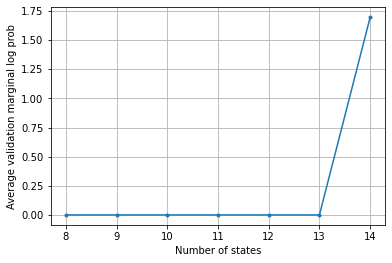

In [9]:
plt.plot(states, avgloglike, '.-')
plt.xlabel('Number of states')
plt.ylabel('Average validation marginal log prob')
plt.grid()
plt.show()
plt.close()

In [ ]:
# Data normalized by open price
norm_stocks = hd.norm_hlc_by_open(stocks, inplace = False)
batches_hlc = hd.batches_norm_hlc_by_open(stocks, period_len)